<a href="https://colab.research.google.com/github/mohibwaqarr/DVLM_Assignment0/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Downloading CIFAR-10...")
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

def get_resnet_baseline(pretrained=True, freeze_backbone=True):

    if pretrained:
        weights = models.ResNet152_Weights.DEFAULT
        model = models.resnet152(weights=weights)
    else:
        model = models.resnet152(weights=None)

    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)

    return model.to(DEVICE)

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total

print("Initializing Baseline Model...")
baseline_model = get_resnet_baseline(pretrained=True, freeze_backbone=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.fc.parameters(), lr=LR)

history_baseline = {'train_loss': [], 'val_acc': []}

print("Starting Baseline Training...")
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(baseline_model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(baseline_model, val_loader, criterion)

    history_baseline['train_loss'].append(train_loss)
    history_baseline['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

print("Baseline Complete.")

Using Device: cuda


100%|██████████| 170M/170M [00:10<00:00, 15.5MB/s] 


Initializing Baseline Model...
Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


100%|██████████| 230M/230M [00:01<00:00, 202MB/s] 


Starting Baseline Training...


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.7040 | Val Acc: 0.8317


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/3 | Train Loss: 0.4901 | Val Acc: 0.8406


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/3 | Train Loss: 0.4493 | Val Acc: 0.8466
Baseline Complete.



=== Task 1.2: Disabling Residual Connections ===
Initializing Broken Model...
Residual connections in Layer 3 (Blocks 0-9) disabled.
Training Broken Model...


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Broken Epoch 1 | Val Acc: 0.1103


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Broken Epoch 2 | Val Acc: 0.1078


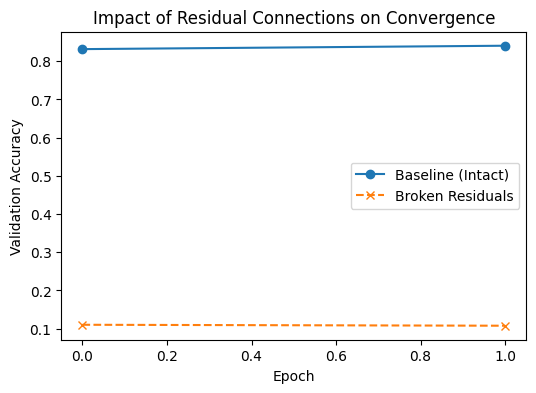


=== Task 1.3: Feature Hierarchies (t-SNE) ===
Extracting features...


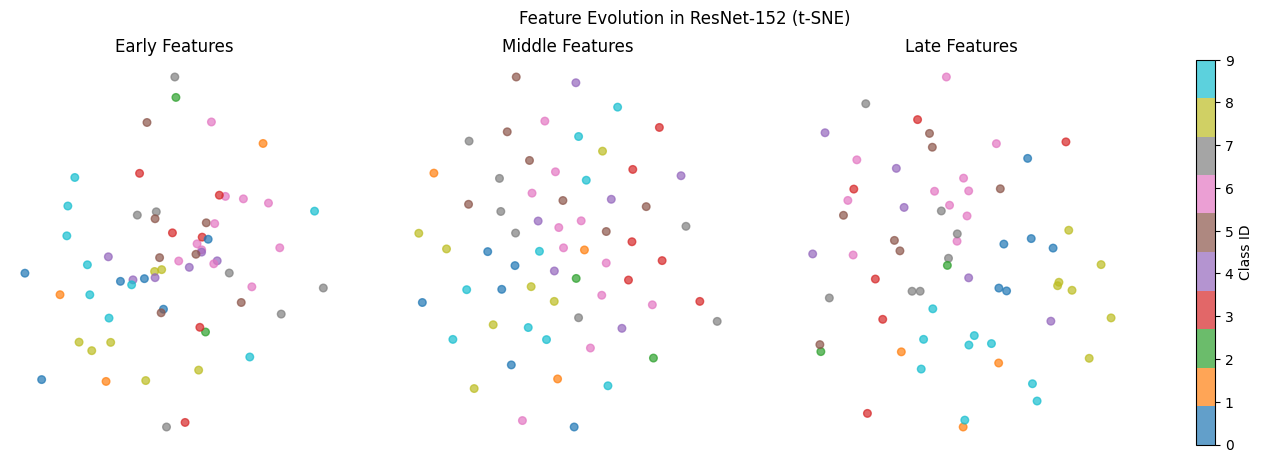


=== Task 1.4: Random Init vs Pretrained ===
Training Random Init Model (1 Epoch Check)...


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Random Init Epoch 1 | Val Acc: 0.4317
Pretrained Frozen Epoch 1 was: 0.8317


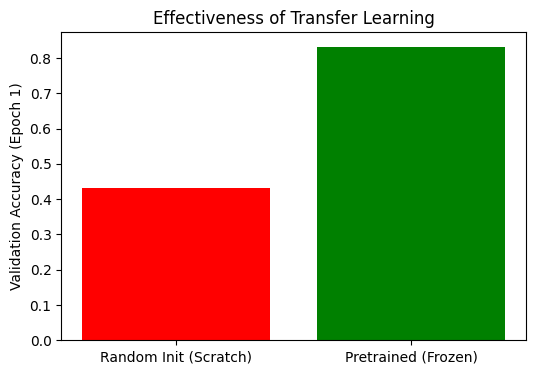

In [ ]:
import types
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("\n=== Task 1.2: Disabling Residual Connections ===")

def broken_bottleneck_forward(self, x):
    identity = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
        identity = self.downsample(x)
    out = self.relu(out)
    return out

print("Initializing Broken Model...")
broken_model = get_resnet_baseline(pretrained=True, freeze_backbone=True)

for i in range(10):
    broken_model.layer3[i].forward = types.MethodType(broken_bottleneck_forward, broken_model.layer3[i])

print("Residual connections in Layer 3 (Blocks 0-9) disabled.")

optimizer_broken = optim.Adam(broken_model.fc.parameters(), lr=LR)
print("Training Broken Model...")
broken_accs = []

for epoch in range(2):
    t_loss, t_acc = train_one_epoch(broken_model, train_loader, criterion, optimizer_broken)
    v_loss, v_acc = evaluate(broken_model, val_loader, criterion)
    broken_accs.append(v_acc)
    print(f"Broken Epoch {epoch+1} | Val Acc: {v_acc:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(history_baseline['val_acc'][:2], label='Baseline (Intact)', marker='o')
plt.plot(broken_accs, label='Broken Residuals', marker='x', linestyle='--')
plt.title("Impact of Residual Connections on Convergence")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.savefig("resnet_broken_residuals.png")
plt.show()


print("\n=== Task 1.3: Feature Hierarchies (t-SNE) ===")

features = {}
def get_activation(name):
    def hook(model, input, output):
        features[name] = output.detach().cpu()
    return hook

h1 = baseline_model.layer1.register_forward_hook(get_activation('early'))
h2 = baseline_model.layer3.register_forward_hook(get_activation('middle'))
h3 = baseline_model.avgpool.register_forward_hook(get_activation('late'))

print("Extracting features...")
data_iter = iter(val_loader)
images, labels = next(data_iter)
images = images.to(DEVICE)

_ = baseline_model(images)

h1.remove()
h2.remove()
h3.remove()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
layer_names = ['early', 'middle', 'late']

for i, name in enumerate(layer_names):
    feats = features[name].view(images.size(0), -1).numpy()

    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(images)-1))
    feats_2d = tsne.fit_transform(feats)

    scatter = axes[i].scatter(feats_2d[:, 0], feats_2d[:, 1], c=labels, cmap='tab10', s=30, alpha=0.7)
    axes[i].set_title(f"{name.capitalize()} Features")
    axes[i].axis('off')

cbar = plt.colorbar(scatter, ax=axes.ravel().tolist())
cbar.set_label('Class ID')
plt.suptitle("Feature Evolution in ResNet-152 (t-SNE)")
plt.savefig("resnet_feature_hierarchy.png")
plt.show()

print("\n=== Task 1.4: Random Init vs Pretrained ===")

random_model = get_resnet_baseline(pretrained=False, freeze_backbone=False)
optimizer_random = optim.Adam(random_model.parameters(), lr=LR)

print("Training Random Init Model (1 Epoch Check)...")

t_loss, t_acc = train_one_epoch(random_model, train_loader, criterion, optimizer_random)
v_loss, v_acc = evaluate(random_model, val_loader, criterion)

print(f"Random Init Epoch 1 | Val Acc: {v_acc:.4f}")
print(f"Pretrained Frozen Epoch 1 was: {history_baseline['val_acc'][0]:.4f}")

plt.figure(figsize=(6, 4))
plt.bar(['Random Init (Scratch)', 'Pretrained (Frozen)'], [v_acc, history_baseline['val_acc'][0]], color=['red', 'green'])
plt.ylabel("Validation Accuracy (Epoch 1)")
plt.title("Effectiveness of Transfer Learning")
plt.savefig("resnet_transfer_learning.png")
plt.show()